# Winequality dataset

## Feim els imports

In [ ]:
#IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

## Preparam el dataset

Funció que separa les features i les etiquetes, escalant les dades

In [ ]:
def load_data(df):
    y=df.quality
    X=df.drop('quality',axis=1)
    X = min_max_scaler.fit_transform(X)
    return X, y

Carregam els datasets a dos dataframes a partir dels fitxers csv: winequality-red.csv i winequality-white.csv

Afegim una nova columna que indiqui el tipus de vi a cada dataset i juntam els dos datasets en un de nou

In [ ]:
#CREATE AND MERGE DATAFRAMES
dfRed=pd.read_csv("winequality-red.csv", sep=";")
dfWhite=pd.read_csv("winequality-white.csv", sep=";")

dfRed['type']="Red"
dfWhite['type']="White"
df=pd.concat([dfRed,dfWhite])

Consultam les files del dataframe amb valors absents i les eliminam

In [ ]:
df[df.isna().any(axis=1)]
df.dropna(inplace=True)

Convertim els valors categòrics en númerics

In [ ]:
labelencoder = LabelEncoder()

df['type']=labelencoder.fit_transform(df['type'])


Recolocam les columnes

In [ ]:
df=df.reindex(columns=['fixed acidity', 'volatile acidity', 'citric acid', 
                       'residual sugar', 'chlorides', 'free sulfur dioxide',
                       'total sulfur dioxide', 'density', 'pH', 'sulphates', 
                       'alcohol', 'type', 'quality'])

In [ ]:
df.info()

In [ ]:
df.head()

Mesclam el dataframe i carregam les dades a les variables *features* (característiques) i *labels* (etiquetes)

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
df = df.sample(frac=1)

features, labels = load_data(df)


### Separació del conjunt d'entrenament i el de test
Per separar les dades en els conjunts d'entrenament i de test hem emprat la funció train_test_split

Hem decidit emprar un 80% entrenament i un 20% de test ja que  amb un valor més baix d'entrenament el model de regressió logistica i el del perceptró presentaven underfiting 


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1)

## Visualització de les dades

Aquí podem observar les correlacions entre els distints atributs

In [ ]:
# dfwithoutType = df.drop('Type', 1)

corr = df.corr()

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        square=True,
        cmap="magma")


Graficam el valor que prenen les característiques númeriques del dataframe mitjançant un histograma

In [ ]:
df.drop("type", axis=1).hist(figsize=(10,10), grid=False)


Gràfic cirular amb el que podem veure la proporció de vi blanc i vermell

In [ ]:
plt.pie(df['type'].value_counts(), labels = ["White","Red"], colors=["khaki","Maroon"])
print(df['type'].value_counts(normalize=True)*100)


# Classificadors

## Regressió Logística

Hem decidit donar-li valor al hiperparàmetre max_iters perquè amb el valor per defecte no arribava a convergir.

In [ ]:
logreg = LogisticRegression(max_iter=5000)
logreg.fit(X_train,y_train)

y_predict = logreg.predict(X_test)

print(classification_report(y_test, y_predict))

training_accuracy = logreg.score(X_train,y_train)
print('training_accuracy:',training_accuracy)

testing_accuracy = logreg.score(X_test,y_test)
print('testing_accuracy:',testing_accuracy)

## Perceptró

In [ ]:
perceptron = Perceptron()
perceptron.fit(X_train, y_train)

y_predict=perceptron.predict(X_test)

print(classification_report(y_test, y_predict))

training_accuracy = perceptron.score(X_train,y_train)
print('training_accuracy:',training_accuracy)

testing_accuracy = perceptron.score(X_test,y_test)
print('testing_accuracy:',testing_accuracy)

## Random Forest

Hem decidit donar-li valor al hiperparàmetre max_depth perquè amb el valor per defecte teniem overfitting.

In [ ]:
rf = RandomForestClassifier(max_depth=14)
rf.fit(X_train, y_train)

y_predict=rf.predict(X_test)

print(classification_report(y_test, y_predict))

training_accuracy = rf.score(X_train,y_train)
print('training_accuracy:',training_accuracy)

testing_accuracy = rf.score(X_test,y_test)
print('testing_accuracy:',testing_accuracy)

## Conclusions
Blablabla

# Enginyeria de característiques

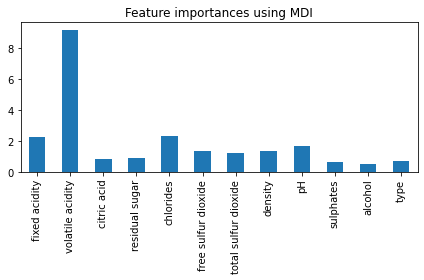

In [157]:
odds = np.exp(logreg.coef_[0])
odds_importances = pd.Series(odds, index=df.drop("quality",axis=1).columns)
fig, ax = plt.subplots()
odds_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
fig.tight_layout()

<class 'pandas.core.series.Series'>


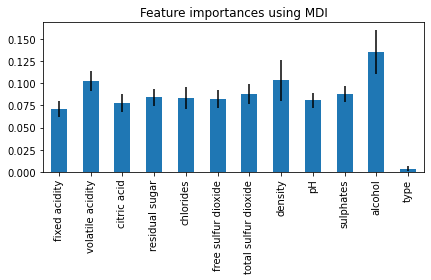

In [155]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=df.drop("quality",axis=1).columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
fig.tight_layout()